Cooperative Co-evolution Genetic Programming

This question is to develop a Cooperative Co-evolution GP (CCGP) to solve this symbolic
regression problem. The CCGP should contain two sub-populations, one for f1(x) and the
other for f2(x)

- Determine and describe the terminal set and the function set of each sub-population.
- Design the fitness function and the fitness evaluation method for each sub-population.
- Set the necessary parameters, such as sub-population size, maximum tree depth, termi-
nation criteria, crossover and mutation rates.
- Run the implemented CCGP for 5 times with different random seeds. Report the best
genetic programs (their structure and performance) of each of the 5 runs. Present your
observations and discussions and draw your conclusions.

In [1]:
import numpy as np
from deap import algorithms, base, creator, tools, gp
from matplotlib import pyplot as plt
import pygraphviz as pgv
import operator
import math
import random

https://github.com/DEAP/deap/blob/fa3abe189e71cb7afef71e0acaaf1a635f083281/examples/gp/symbreg.py

In [2]:

# Define new functions
def protectedDiv(left, right):
    # for protected division
    try:
        return left / right
    except ZeroDivisionError:
        return 1.0

def boolean(input): return input !=  0 # boolean function
def if_then_else(input, output1, output2): return  output1 if input else output2
def square(input): 
    try:
        return math.pow(input, 2) 
    except OverflowError:
        return float("inf")


Then, we need to define the primitive set (terminal set and the function set )

In [3]:
# we use the Strongly Typed GP to ensure the type of the terminal and function
# inpput is [float] i.e. 1 input arg , output is float
import time


pset = gp.PrimitiveSetTyped("main", [float], float) 
# for the function set, we add the following functions
# add, mul, protectedDiv, sin, cos, tan, square, boolean, if_then_else
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)
pset.addPrimitive(math.sin, [float], float)
pset.addPrimitive(math.cos, [float], float)
pset.addPrimitive(math.tan, [float], float)
pset.addPrimitive( square, [float], float)
pset.addPrimitive(boolean, [float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# then, we add the terminal set
pset.addTerminal(1, bool)
pset.addTerminal(0, bool)
pset.addEphemeralConstant(f"eph_const{time.time()}",lambda: random.randint(-20, 20), float)

pset.renameArguments(ARG0="x")

https://blog.csdn.net/sinat_41596046/article/details/120187905?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-120187905-blog-120229791.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-120187905-blog-120229791.pc_relevant_default&utm_relevant_index=3

Example of how to create a gp expression, and compile the expression]

In [4]:
# # create the expressions accpording to the above pset
# expr1 = gp.genHalfAndHalf(pset, min_=1, max_=3)
# expr2 = gp.genFull(pset,0,2)    # list
# expr3 = gp.genGrow(pset,1,3)
# tree = gp.PrimitiveTree(expr1) # convert the expression to tree

# # compile the expr: must compile before using
# function1 = gp.compile(expr1, pset)
# function2 = gp.compile(expr2, pset)  
# result = function1(1,2)   # check the result by inputing 1,2
# print('result:',result)



Then, create individual and register tool box

In [5]:
# create("className", parentClass, attribute1, attribute2, ...)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# expr = gp.genHalfAndHalf(pset=pset, min_=1, max_=3)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)

toolbox.register("individual" , tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


define the fitness  function and the fitness evaluation method for each sub-population.

In [6]:
def real_piecewise_func(x):
    if x > 0:
        return 1/x + math.sin(x)
    else:
        return 2*x + (x**2) + 3.0

def evalSymbReg(individuals, points):
    """The evaluation function takes a list of individuals to be evaluated including the representatives of the other species and possibly some other arguments. 
    
    Returns : the  computed collaboration fitness
    """
    # as we have 2 species, we need to split the individuals into 2 groups
    f1, f2 = toolbox.compile(individuals[0]), toolbox.compile(individuals[1])
    # the real function is 
    # f1(x) = 1/x + sin x,  x > 0
    # f2(x) = 2x +x^2 + 3.0, x <= 0
    # we use the mean square error as the fitness
    sqerrors = [
        (f1(x) - real_piecewise_func(x))**2 if x > 0 
        else (f2(x) - real_piecewise_func(x))**2 for x in points
    ]
    result = math.fsum(sqerrors) / len(points)
    return result,



define some hyperparameters

In [7]:
SPECIES_SIZE = 500
NUM_SPECIES = 2
CXPB, MUTPB = 0.85, 0.15 # the probability for crossover and mutation
MAX_GENS = 500 # the maximum number of generations


In [8]:
# we are evaluating the range of [-20, 20]
toolbox.register("evaluate", evalSymbReg, points=[x/1. for x in range(-20,21)])
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("select_best", tools.selBest, k = 1)
toolbox.register("mate", gp.cxOnePoint)
#we use subtree mutation, which will choose a random subtree and replace it with a randomly generated subtree
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2) # generate a random subtree
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) # replace the subtree with the random subtree
# ensure the lengith of the tree is less than 10
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
# specify the number of species

toolbox.register("species", tools.initRepeat, list, toolbox.individual, n=SPECIES_SIZE)



https://github.dev/DEAP/deap/blob/fa3abe189e71cb7afef71e0acaaf1a635f083281/examples/coev/

In [9]:
# run the algorithm 
def CCGP():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "species", "evals", "std", "min", "avg", "max"
    
    species = [toolbox.species() for _ in range(NUM_SPECIES)]
    species_index = list(range(NUM_SPECIES))
    
    representatives = [random.choice(species[i]) for i in species_index]
    
    for gen in range(MAX_GENS):
        # Initialize a container for the next generation representatives
        next_repr = [None] * len(species)
        
        #  evolve the representatives of each species
        for i in species_index:
            current_species = species[i]
            # vary the current species
            offspring_species = algorithms.varAnd(current_species, toolbox, CXPB, MUTPB)
            # get the representatives except the current one
            reprsentatives_others = representatives[:i] + representatives[i+1:]
            for individual in offspring_species:
                # we have only 2 speices, so we need to evaluate the individual with the representatives of the other species_index
                if i == 0:
                    individual.fitness.values = toolbox.evaluate([individual, reprsentatives_others[0]])
                else: 
                    individual.fitness.values = toolbox.evaluate([reprsentatives_others[0], individual])
            # tournament selection
            offspring_species = toolbox.select(offspring_species, len(offspring_species))
            # replace the current species with the offspring species
            species[i] = offspring_species
            
            # select the best individual of the current species as the next representative
            repr = toolbox.select_best(offspring_species)[0]
            next_repr[i] = repr
            
            # record the statistics
            record = stats.compile(offspring_species)
            logbook.record(gen=gen, species=i, evals=len(offspring_species), **record)
            
        
        # update the representatives
        representatives = next_repr
        
    return representatives, logbook

def plot_tree(treeExpr, title, seed):
    nodes, edges, labels = gp.graph(treeExpr)
    g = pgv.AGraph()
    if title == 'f1':
        g.add_node(-1, color='red', style='filled', label=f'seed_{seed}:f1(x) for x > 0', shape='box')
    else :
        g.add_node(-1, color='blue', style='filled', label=f'seed_{seed}:f2(x) for x <= 0', shape='box')
    
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")
    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
    g.draw(f"tree_{title}_seed{seed}.pdf")

    # print the tree expr
    print(f"tree_{title}_seed{seed} = {treeExpr}")
    
    # plot the tree in the notebook
    # return Image(filename=f"tree_{title}_{seed}.pdf")
    
def plot_result(representatives, logbook, seed):
    f1, f2 = toolbox.compile(representatives[0]), toolbox.compile(representatives[1])
    # x = [x/1. for x in range(-20,21)]
    
    x_above_0 = [x/1. for x in range(1,21)]
    x_below_equal_0 = [x/1. for x in range(-20,1)]
    
    y_real = [real_piecewise_func(x) for x in x_above_0 + x_below_equal_0]
    y1 = [f1(x) for x in x_above_0]
    y2 = [f2(x) for x in x_below_equal_0]
    # we need to plot the 2 functions in the 2 subplots, one for x > 0, the other for x <= 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # for ax2, plot the real function in red , and f2 in blue
    ax1.plot(x_below_equal_0, y_real[len(x_above_0):], color='red', label='real function')
    ax1.plot(x_below_equal_0, y2, color='blue', label='f2')
    ax1.set_title('f2(x) for x <= 0')
    ax1.legend()

    # for ax1, plot the real function in red , and f1 in blue
    ax2.plot(x_above_0, y_real[:len(x_above_0)], color='red', label='real function')
    ax2.plot(x_above_0, y1, color='blue', label='f1')
    ax2.set_title('f1(x) for x > 0')
    ax2.legend()
    
    # add the title for the seed 
    fig.suptitle(f'Seed: {seed}')
    plt.show()
    
    
    # plot the trees
    plot_tree(representatives[0], 'f1', seed)
    plot_tree(representatives[1], 'f2', seed)
    
    
    
def run_CCGP_n_times(n=5):
    """Run the CCGP algorthims for N times with different random seeds.
    Report the best gp programs(their structure and performance), and the average performance of the best programs.
   """
    best_programs = []
    best_fitnesses = []
    for seed in range(n):
        random.seed(seed)
        np.random.seed(seed)
        representatives, logbook = CCGP()
        plot_result(representatives, logbook, seed)
        best_programs.append(representatives)
        best_fitnesses.append(logbook.select("min")[-1])
    # print(f"the best programs are {best_programs}")
    print("-"*50)
    print("-"*50)
    print(f"the best fitnesses are {best_fitnesses}")
    print(f"the average fitness is {np.mean(best_fitnesses)}")
   
   

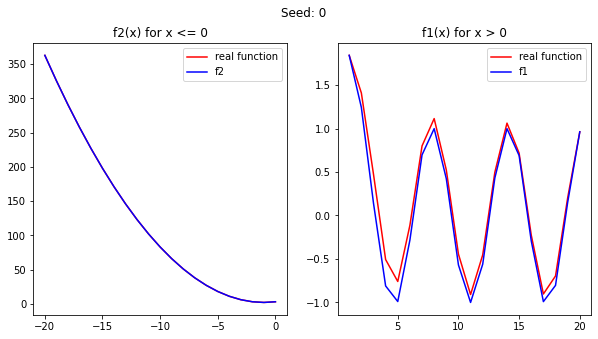

tree_f1_seed0 = if_then_else(boolean(add(if_then_else(boolean(add(if_then_else(boolean(x), if_then_else(1, x, protectedDiv(x, -17)), add(7, tan(-9))), -1)), if_then_else(boolean(-18), add(if_then_else(1, x, -3), -1), x), 1), -1)), sin(tan(sin(x))), if_then_else(boolean(if_then_else(0, tan(x), if_then_else(boolean(-15), tan(x), x))), add(if_then_else(boolean(add(if_then_else(boolean(x), sin(x), -3), -1)), x, x), sin(square(x))), if_then_else(boolean(sin(1)), if_then_else(boolean(x), if_then_else(boolean(x), x, add(add(protectedDiv(protectedDiv(mul(17, 0), add(x, 0)), 7), if_then_else(1, sin(-1), x)), add(mul(if_then_else(boolean(-11), x, x), 1), 8))), protectedDiv(x, if_then_else(boolean(add(square(x), x)), x, -6))), if_then_else(boolean(sin(x)), sin(x), if_then_else(boolean(tan(2)), if_then_else(boolean(x), -1, -3), protectedDiv(if_then_else(boolean(0), -9, -1), x))))))
tree_f2_seed0 = add(square(if_then_else(boolean(3), x, if_then_else(1, if_then_else(1, add(if_then_else(1, if_then_el

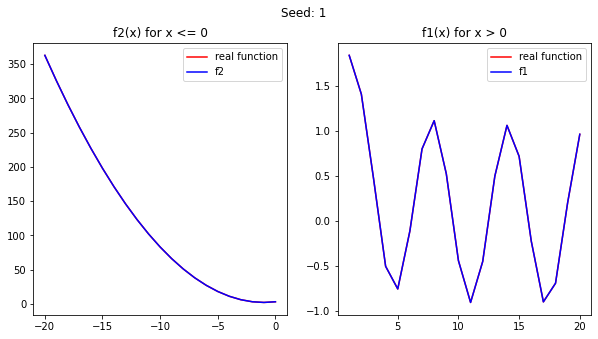

tree_f1_seed1 = add(sin(x), protectedDiv(cos(tan(0)), if_then_else(0, if_then_else(boolean(x), if_then_else(boolean(if_then_else(boolean(-5), add(8, x), tan(square(square(x))))), cos(tan(-14)), mul(sin(x), x)), add(protectedDiv(sin(if_then_else(0, -6, x)), if_then_else(boolean(9), mul(mul(14, sin(-20)), square(0)), x)), x)), if_then_else(0, if_then_else(0, tan(add(x, x)), x), x))))
tree_f2_seed1 = add(mul(if_then_else(0, add(if_then_else(boolean(x), 3, if_then_else(0, square(0), x)), sin(protectedDiv(x, -8))), if_then_else(boolean(x), if_then_else(boolean(x), if_then_else(0, x, x), if_then_else(0, if_then_else(0, if_then_else(0, 3, if_then_else(1, x, x)), tan(x)), x)), 3)), x), add(add(if_then_else(0, x, if_then_else(0, if_then_else(0, 14, add(if_then_else(0, x, x), add(x, x))), x)), 3), if_then_else(0, 12, if_then_else(0, sin(cos(if_then_else(0, add(if_then_else(0, if_then_else(0, x, 8), x), if_then_else(boolean(x), tan(x), x)), x))), if_then_else(0, tan(-14), x)))))


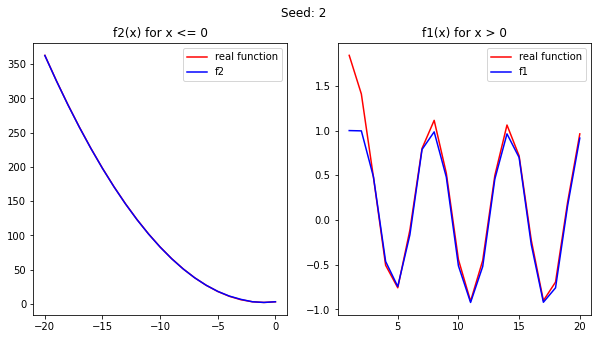

tree_f1_seed2 = sin(tan(sin(tan(add(sin(sin(if_then_else(boolean(add(x, -1)), x, 19))), square(protectedDiv(-2, if_then_else(boolean(add(x, -3)), x, cos(-14)))))))))
tree_f2_seed2 = add(if_then_else(0, add(protectedDiv(add(square(sin(add(-13, -3))), x), square(sin(20))), add(if_then_else(boolean(x), if_then_else(0, tan(x), square(x)), 4), x)), add(x, if_then_else(boolean(if_then_else(0, if_then_else(boolean(x), mul(mul(x, cos(15)), if_then_else(1, cos(-9), x)), square(square(if_then_else(1, x, x)))), add(x, if_then_else(1, 2, square(x))))), 2, add(tan(x), add(cos(mul(add(square(x), if_then_else(0, x, 9)), protectedDiv(sin(-11), sin(x)))), cos(-9)))))), mul(if_then_else(boolean(add(if_then_else(boolean(x), if_then_else(0, tan(x), square(x)), 4), x)), add(x, cos(add(protectedDiv(sin(20), protectedDiv(x, -3)), tan(-3)))), x), if_then_else(boolean(x), if_then_else(boolean(add(15, 7)), x, x), add(cos(add(protectedDiv(sin(tan(-3)), protectedDiv(x, -3)), tan(-3))), if_then_else(boolean(add(if

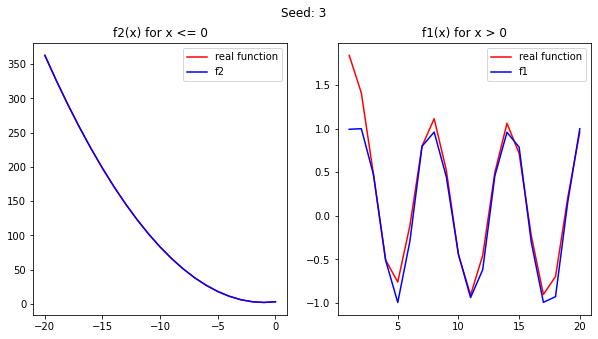

tree_f1_seed3 = sin(if_then_else(boolean(add(add(x, -8), add(add(if_then_else(boolean(add(x, -4)), x, x), -8), -4))), tan(sin(if_then_else(boolean(add(add(x, 1), -4)), if_then_else(boolean(add(x, -4)), tan(tan(sin(sin(x)))), square(12)), protectedDiv(8, x)))), if_then_else(boolean(add(add(x, 1), -4)), mul(sin(if_then_else(boolean(add(x, x)), -4, 16)), 16), tan(mul(if_then_else(boolean(add(add(x, 1), -4)), tan(x), square(16)), 9)))))
tree_f2_seed3 = add(add(x, if_then_else(0, if_then_else(0, x, if_then_else(0, x, add(x, x))), add(if_then_else(0, square(protectedDiv(sin(x), x)), add(if_then_else(0, mul(x, cos(mul(x, 0))), add(x, cos(mul(x, 0)))), protectedDiv(x, x))), cos(mul(0, 0))))), square(x))


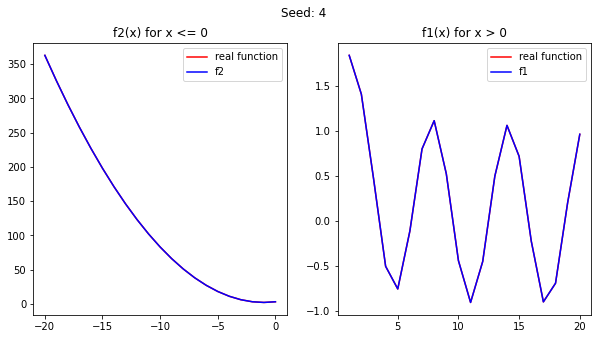

tree_f1_seed4 = if_then_else(0, mul(mul(sin(x), cos(5)), mul(sin(protectedDiv(if_then_else(0, square(square(-10)), x), 1)), if_then_else(0, x, 20))), add(sin(x), protectedDiv(1, protectedDiv(x, 1))))
tree_f2_seed4 = add(square(protectedDiv(square(if_then_else(0, mul(if_then_else(0, if_then_else(0, x, x), x), if_then_else(0, x, protectedDiv(x, square(tan(11))))), x)), x)), add(protectedDiv(square(x), protectedDiv(mul(mul(if_then_else(0, if_then_else(0, mul(x, x), sin(x)), x), if_then_else(0, x, if_then_else(1, 3, x))), x), add(add(mul(3, x), protectedDiv(protectedDiv(sin(3), square(tan(11))), square(mul(tan(11), tan(11))))), square(3)))), protectedDiv(square(if_then_else(0, protectedDiv(protectedDiv(sin(3), square(mul(if_then_else(0, x, 11), if_then_else(0, x, x)))), mul(if_then_else(0, x, 11), if_then_else(0, x, x))), x)), x)))
--------------------------------------------------
--------------------------------------------------
the best fitnesses are [0.01444149059376879, 0.0, 0.043752

In [10]:

run_CCGP_n_times()
